In [1]:
"""

    credit :Zhejie Ding, https://github.com/zdplayground/emcee_fit_Pwnw
    
    
    Copy the code mcmc_fit_nonlinear_BAO from /Users/ding/Documents/playground/shear_ps/SVD_ps/mcmc_fit
    modify it to fit observed power spectrum Pwig with damped BAO.
    Modify the function cal_pk_model in the lnprob module for the fitting model:
    Pwig(k') = A*((Plin(k) - Psm(k))*exp(-k^2*Sigma^2/2) + Psm(k)) + B; --09/25/2017
"""


import emcee
#from emcee.utils import MPIPool
from mpi4py import MPI
import time
import numpy as np
import scipy.optimize as op
from scipy import linalg
from scipy.interpolate import InterpolatedUnivariateSpline
from functools import reduce
import os, sys
from baoutils import match_params, cal_pk_model, lnprior
import matplotlib.pyplot as plt
#from matplotlib.ticker import MaxNLocator
import argparse
import corner
import sys
sys.path.append('/Users/mehdi/github/LSSutils')
from LSSutils.utils import D as growth_factor

camb is not installed!


In [2]:
def gelman_rubin_convergence(withinchainvar, meanchain, n, Nchains, ndim):
    """
    Gelman & Rubin convergence criterion, 
    referenced from Florian's code RSDfit_challenge_hex_steps_fc_hoppper.py

     Calculate Gelman & Rubin diagnostic
     1. Remove the first half of the current chains
     2. Calculate the within chain and between chain variances
     3. estimate your variance from the within chain and between chain variance
     4. Calculate the potential scale reduction parameter
     
     
     parameters
     ----------
     withinchainvar :
     meanchain : 
     n : 
     Nchains : 
     ndim : 
     
     returns
     -------
     scalereduction :
     
    """
    meanall = np.mean(meanchain, axis=0)
    W       = np.mean(withinchainvar, axis=0)
    B       = np.zeros(ndim, dtype=np.float)
    
    for jj in range(0, Nchains):
        
        B = B + n*(meanall - meanchain[jj])**2/(Nchains-1.)
        
    estvar = (1. - 1./n)*W + B/n
    scalereduction = np.sqrt(estvar/W)
    return scalereduction


def write_params(filename, params_mcmc, params_name, reduced_chi2):
    """
      write parameters fitted in files
      
      
      parameters
      ----------
      filename : str
      params_mcmc : list of float
      params_name : list of str
      reduced_chi2 : float
      
      
    """
    header_line = '# The fitted parameters {} (by row) with their upward'\
                + ' and downward one sigma error, and the reduced \chi^2.\n'\
                .format(params_name[:])

    with open(filename, 'w') as fwriter:
        
        fwriter.write(header_line)
        
        for i in range(len(params_name)):
            
            fwriter.write("#{0}: {1:.7f} {2:.7f} {3:.7f}\n"\
                   .format(params_name[i], params_mcmc[i][0],
                           params_mcmc[i][1], params_mcmc[i][2]))
            
        fwriter.write("#reduced_chi2: {0:.7f}".format(reduced_chi2))


        
def set_params(all_params, params_indices, all_names, all_temperature):
    """
     Define a function to set parameters which are free and which are fixed.
     
     
     parameters
     ----------
     all_params :
     params_indices : 
     all_names :
     all_temperature : 
     
     
     returns
     --------
     N_params :
     theta :
     fix_params :
     params_T :
     params_name :
     
    """
    fix_params  = np.array([], dtype=np.float)
    theta       = np.array([], dtype=np.float)
    params_T    = np.array([], dtype=np.float)
    params_name = []
    
    N_params = 0
    count    = 0
    for i in params_indices:
        
        if i == 1:
            
            fix_params = np.append(fix_params, 0.)
            theta      = np.append(theta, all_params[count])
            params_T   = np.append(params_T, all_temperature[count])
            params_name.append(all_names[count])
            N_params += 1
            
        else:
            
            fix_params = np.append(fix_params, all_params[count])
            
        count += 1
        
    print(theta, params_name, N_params)
    print("fixed params: ", fix_params)
    
    return N_params, theta, fix_params, params_T, params_name


"""
 Input observed Pk_obs(k') = Pwig(k').
 If the observed and input power spectrum have different redshifts,
 we need norm_gf as the normalized growth factor D(z). Here since we introduce the parameter A,
 we don't need growth function. But still keep the parameter in the code now. -- 09/25/2017
"""
def lnlike(theta, params_indices, fix_params, k_p, 
           Pk_obs, ivar, Pwig_spl, Psm_spl, norm_gf):
    '''
        lnLikelihood
        
        
        parameters
        -----------
        theta :
        params_indices : 
        fix_params :
        k_p :  
        Pk_obs :
        ivar :
        Pwig_spl :
        Psm_spl :
        norm_gf :
    
        returns
        ----------
        lnLikelihood = -0.5 \Sum [[Pmodel - Pobs]/error]^2
    
    '''
    # call Fortran
    alpha, Sigma2_xy, A, B = match_params(theta, params_indices, fix_params)
    
    coeff    = 1.0/alpha
    k_t      = k_p*coeff        # k=k'/alpha
    Pk_linw  = Pwig_spl(k_t)
    Pk_sm    = Psm_spl(k_t)
    
    # call Fortran
    Pk_model = cal_pk_model(Pk_linw, Pk_sm, k_t, Sigma2_xy, A, B)
    
    diff     = Pk_model - Pk_obs
    
    return -0.5* np.dot(diff*diff, ivar)



def lnprob(theta, params_indices, fix_params, k_p, 
           Pk_obs, ivar, Pwig_spl, Psm_spl, norm_gf):
    ''' Posterior
    
    
        parameters
        ----------
        theta :
        params_indices :
        fix_params :
        k_p :
        Pk_obs :
        ivar :
        Pwig_spl :
        Psm_spl :
        norm_gf :
        
        
        returns
        -------
        LnPosterior = lnPrior + lnLikelihood
    
    '''
    # call fortran
    lp = lnprior(theta, params_indices, fix_params)
    
    if (lp < -1.e20):
        return -np.inf
    
    return lp + lnlike(theta, params_indices, fix_params, k_p,
                       Pk_obs, ivar, Pwig_spl, Psm_spl, norm_gf)



# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)


# MCMC routine
def mcmc_routine(ndim, N_walkers, theta, params_T, params_indices, 
                 fix_params, k_range, Pk_obs, ivar_Pk_obs, Pwig_spl, 
                 Psm_spl, norm_gf, params_name, pool):
    
    '''
        MCMC routine
        
        parameters
        ----------
        ndim :
        N_walkers : 
        theta :
        params_T :
        params_indices :
        fix_params :
        k_range : 
        Pk_obs :
        ivar_Pk_obs : 
        Pwig_spl :
        Psm_spl :
        norm_gf :
        params_name :
        pool :
        
        
        returns
        ---------
        theta_mcmc : 
    '''
    ti = time.time()

    Nchains     = 10
    minlength   = 800
    epsilon     = 0.01
    ichaincheck = 50
    #if not pool is None:        
    #    #if not pool.is_master():
    #    #    pool.wait()
    #    #    sys.exit(0)

    result = op.minimize(chi2, theta, args=(params_indices, fix_params, k_range,\
                         Pk_obs, ivar_Pk_obs, Pwig_spl, Psm_spl, norm_gf),\
                         method='Powell')
    theta_optimize = result["x"]

    # only output parameters which are free to change
    print("Parameters from Powell optimization: ", theta_optimize)
    theta_optimize = theta
    print("Initial parameters for MCMC: ", theta_optimize)

    pos = []
    sampler = []
    rstate = np.random.get_state()
    # Set up the sampler.
    for jj in range(Nchains):
        pos.append([theta_optimize + params_T*np.random.uniform(-1.0, 1.0, ndim) for i in range(N_walkers)])
        sampler.append(emcee.EnsembleSampler(N_walkers, ndim, lnprob, a=2.0,\
                args=(params_indices, fix_params, k_range, Pk_obs, ivar_Pk_obs,\
                      Pwig_spl, Psm_spl, norm_gf), pool=pool))
    print(type(sampler))

    # Clear and run the production chain.
    print("Running MCMC...")

    withinchainvar = np.zeros((Nchains,ndim))
    meanchain = np.zeros((Nchains,ndim))
    scalereduction = 2.*np.ones(ndim,dtype=np.float)
    itercounter = 0
    chainstep = minlength
    loopcriteria = 1
    num_iteration = 1
    while loopcriteria and num_iteration<50:
        itercounter = itercounter + chainstep
        print("chain length =",itercounter," minlength =",minlength)

        for jj in range(Nchains):
            # Since we write the chain to a file we could put storechain=False, but in that case
            # the function sampler.get_autocorr_time() below will give an error
            for result in sampler[jj].sample(pos[jj], iterations=chainstep,\
                                             rstate0=np.random.get_state(),\
                                              thin=1): # storechain=True,
                pos[jj] = result.coords
                #print(pos)
                #chainchi2 = -2.*result.log_prob
                #rstate = result.random_state[2]

            # we do the convergence test on the second half of the current chain (itercounter/2)
            chainsamples = sampler[jj].chain[:, itercounter//2:, :].reshape((-1, ndim))
            #print("len chain = ", chainsamples.shape)
            withinchainvar[jj] = np.var(chainsamples, axis=0)
            meanchain[jj] = np.mean(chainsamples, axis=0)

        scalereduction = gelman_rubin_convergence(withinchainvar, meanchain,\
                                                  itercounter//2, Nchains, ndim)
        print("scalereduction = ", scalereduction)
        loopcriteria = 0
        for jj in range(0, ndim):
            if np.absolute(1.0-scalereduction[jj]) > epsilon:
                loopcriteria = 1
        chainstep = ichaincheck
        num_iteration = num_iteration + 1
    print("Done.")

    # Print out the mean acceptance fraction. In general, acceptance_fraction
    # has an entry for each walker so, in this case, it is a 250-dimensional vector.
    for jj in range(0, Nchains):
        print("Mean acceptance fraction for chain ", jj,": ", np.mean(sampler[jj].acceptance_fraction))
    # Estimate the integrated autocorrelation time for the time series in each parameter.
    #for jj in range(0, Nchains):
    #    print("Autocorrelation time for chain ", jj,": ", sampler[jj].get_autocorr_time())
    ###################################
    ## Compute the quantiles ##########
    ###################################

    #samples=[]
    mergedsamples=[]

    for jj in range(0, Nchains):
        #samples.append(sampler[jj].chain[:, itercounter/2:, :].reshape((-1, ndim)))
        mergedsamples.extend(sampler[jj].chain[:, itercounter//2:, :].reshape((-1, ndim)))
    print("length of merged chain = ", sum(map(len,mergedsamples))//ndim)

    theta_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
                     zip(*np.percentile(mergedsamples, [15.86555, 50, 84.13445], axis=0)))
    theta_mcmc = list(theta_mcmc)

    print("MCMC result: ")
    for i in range(len(theta)):
        print("{0}={1[0]}+{1[1]}-{1[2]}".format(params_name[i], theta_mcmc[i]))

    del sampler
    tf = time.time()
    print("One mcmc running set time: ", tf-ti)
    return np.array(theta_mcmc), mergedsamples

In [3]:
# Fit extracted power spectrum from shear power spectrum. We use Pwig/Pnow as the observable.
def fit_BAO(args):
    '''
    
    
    
    
    
    '''
    
    kmin           = args.kmin
    kmax           = args.kmax
    params_str     = args.params_str
    params_indices = [int(i) for i in params_str]

    
    #---- paths
    odir = './baofit_kmin{}_kmax{}_{}/'.format(kmin, kmax, 'test')
    if not os.path.exists(odir):
        os.makedirs(odir)

    ofile = odir + "mcmc_fit_params{}.log".format(params_str)
    print('Arguments for the fitting: ', args)

    ifile = './planck_wiggle.dat'
    klin, Pk_linw = np.loadtxt(ifile, usecols=(0,1), unpack=True)
    Pwig_spl = InterpolatedUnivariateSpline(klin, Pk_linw)

    ifile = './planck_smooth.dat'
    klin, Pk_sm = np.loadtxt(ifile, usecols=(0,1), unpack=True)
    Psm_spl = InterpolatedUnivariateSpline(klin, Pk_sm)

    #---- MPI stuff
    #comm = MPI.COMM_WORLD
    #rank = comm.Get_rank()
    #size = comm.Get_size()
    #if rank == 0:
    #    if not os.path.exists(odir):
    #        os.makedirs(odir)

    #pool = MPIPool(loadbalance=True)
    pool=None
    
    #---- parameters 
    # initial guess for fitting, Sigma2_xy=31.176 at z=0.65 is from theory prediction
    norm_gf         = 1.0
    N_walkers       = 40
    redshift        = 1.1
    alpha, A, B     = 1.0, 1.0, 10.0
    all_param_names = 'alpha', 'Sigma2_xy', 'A', 'B'
    all_temperature = 0.01, 1.0, 0.1, 0.1
    Omega_m         = 0.3075              # matter density
    G_0             = growth_factor(0.0, Omega_m)
    Sigma_0         = 7.7840       # This is exactly calculated from theoretical prediction with q_{BAO}=110 Mpc/h.

    norm_gf         = growth_factor(redshift, Omega_m)/G_0
    Sigma2_xy       = (Sigma_0*norm_gf)**2.0
    all_params      = alpha, Sigma2_xy, A, B
    N_params, theta, fix_params, params_T, params_name = set_params(all_params, 
                                                                    params_indices, 
                                                                    all_param_names, 
                                                                    all_temperature)    
    print('z, Sigma2_xy: ', redshift, Sigma2_xy)


    #---- read the observed 
    ifile    = '/Users/mehdi/Downloads/pk_v0_26_red_1_0.5.txt'
    data_m   = np.loadtxt(ifile) # k, P0(k), P2(k), N_modes
    indices  = (data_m[:,0] >= kmin) & (data_m[:,0] <= kmax)
    N_fitbin = indices.sum()

    ## MR: no # modes
    k_obs, Pk_wig_obs, N_modes = data_m[indices, 0], data_m[indices, 1], 1.0
    ivar_Pk_wig = N_modes/(2.0 * Pk_wig_obs**2.0)
    #print('ivar_Pk_wig', ivar_Pk_wig)

    params_mcmc, samples = mcmc_routine(N_params, N_walkers, theta, params_T,\
                                           params_indices, fix_params, k_obs, Pk_wig_obs,\
                                           ivar_Pk_wig, Pwig_spl, Psm_spl, norm_gf, params_name, pool)
        
    print(params_mcmc)
    chi_square = chi2(params_mcmc[:, 0], params_indices, fix_params,\
                      k_obs, Pk_wig_obs, ivar_Pk_wig, Pwig_spl, Psm_spl, norm_gf)
    reduced_chi2 = chi_square/(N_fitbin-N_params)
    print("chi^2/dof: ", reduced_chi2, "\n")
    ofile_params = odir + 'fit_p0_z{}_params{}.dat'.format(redshift, params_str)
    write_params(ofile_params, params_mcmc, params_name, reduced_chi2)
    return samples

    #pool.close()
    #sys.stdout = old_stdout
    #log_file.close()

In [4]:
class Args:
    def __init__(self, kmin, kmax, params_str):
        self.kmin = kmin
        self.kmax = kmax
        self.params_str = params_str
    def __repr__(self):
        return '{}'.format(self.__dict__)        

In [5]:
kpk1 = np.loadtxt('./planck_smooth.dat')
kpk2 = np.loadtxt('./planck_wiggle.dat')
kpk3 = np.loadtxt('/Users/mehdi/Downloads/pk_v0_26_red_1_0.5.txt')

[0.0001, 1.0, 1, 100000000.0]

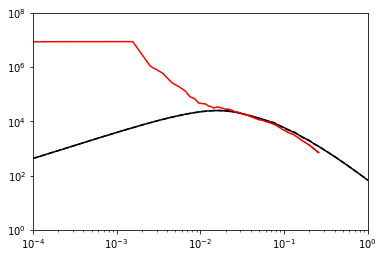

In [6]:
plt.plot(kpk1[:,0], kpk1[:,1], 'k-',
         kpk2[:,0], kpk2[:,1], 'k--',
         kpk3[:,0], kpk3[:,1], 'r-')
plt.yscale('log')
plt.xscale('log')
plt.axis([1.e-4, 1., 1, 1.e8])

In [7]:
args = Args(7.e-3, 1.e-1, '1111')

In [8]:
args

{'kmin': 0.007, 'kmax': 0.1, 'params_str': '1111'}

In [9]:
samples  = fit_BAO(args)

Arguments for the fitting:  {'kmin': 0.007, 'kmax': 0.1, 'params_str': '1111'}
[ 1.         20.63832121  1.         10.        ] ['alpha', 'Sigma2_xy', 'A', 'B'] 4
fixed params:  [0. 0. 0. 0.]
z, Sigma2_xy:  1.1 20.638321208141445
Parameters from Powell optimization:  [4.54692020e-01 1.64698194e+03 1.83756675e+00 2.29511805e+03]
Initial parameters for MCMC:  [ 1.         20.63832121  1.         10.        ]
<class 'list'>
Running MCMC...
chain length = 800  minlength = 800
scalereduction =  [1.00152199 1.0011249  1.00062804 1.00099678]
Done.
Mean acceptance fraction for chain  0 :  0.48175
Mean acceptance fraction for chain  1 :  0.47921874999999997
Mean acceptance fraction for chain  2 :  0.4751250000000001
Mean acceptance fraction for chain  3 :  0.47524999999999995
Mean acceptance fraction for chain  4 :  0.47871874999999997
Mean acceptance fraction for chain  5 :  0.47953124999999996
Mean acceptance fraction for chain  6 :  0.4788125
Mean acceptance fraction for chain  7 :  0.47718

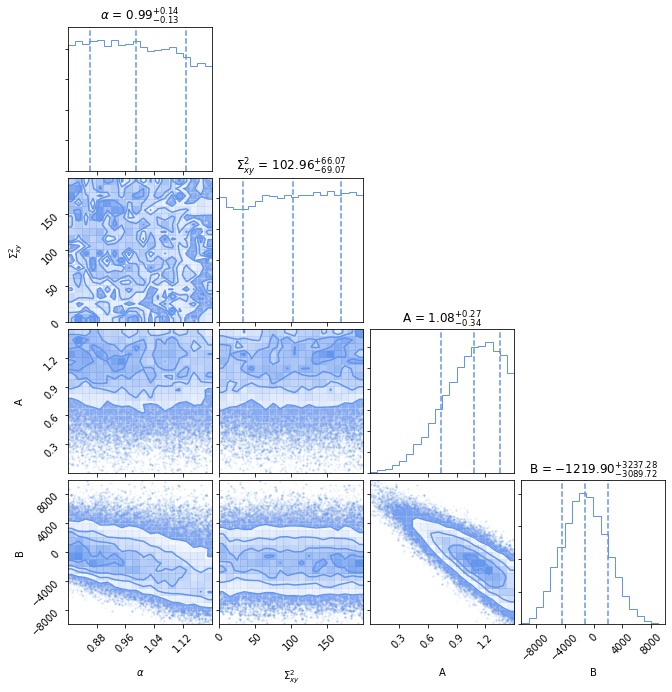

In [13]:
fig = corner.corner(samples, labels=[r'$\alpha$', r'$\Sigma^{2}_{xy}$', 'A', 'B'],
                    quantiles=[.1586555, .50, .8413445], show_titles=True, color='cornflowerblue',
                    plot_contours=True, ) #    truths=[.1, 0.1, 0.2], 

In [11]:
help(corner.corner)

Help on function corner in module corner.corner:

corner(xs, bins=20, range=None, weights=None, color='k', smooth=None, smooth1d=None, labels=None, label_kwargs=None, show_titles=False, title_fmt='.2f', title_kwargs=None, truths=None, truth_color='#4682b4', scale_hist=False, quantiles=None, verbose=False, fig=None, max_n_ticks=5, top_ticks=False, use_math_text=False, hist_kwargs=None, **hist2d_kwargs)
    Make a *sick* corner plot showing the projections of a data set in a
    multi-dimensional space. kwargs are passed to hist2d() or used for
    `matplotlib` styling.
    
    Parameters
    ----------
    xs : array_like[nsamples, ndim]
        The samples. This should be a 1- or 2-dimensional array. For a 1-D
        array this results in a simple histogram. For a 2-D array, the zeroth
        axis is the list of samples and the next axis are the dimensions of
        the space.
    
    bins : int or array_like[ndim,]
        The number of bins to use in histograms, either as a fixe